<a href="https://colab.research.google.com/github/hieuhannguyen/experiential_learning/blob/main/Analysis_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analytics questions:
1. What are trends among classes that submit a syllabus over the years? What percentage of the total number of classes? How does this percentage look if we group by "Semester Offer"?
2. What are the different types of assessment instructors typically issue in classes? Among these types, which classes are more likely to issue one assessment over others?
3. Are there classes that mention experiential learning? How about reflection?

In [ ]:
# connect the engine to GoogleDrive. Please accept *all* terms and conditions when prompted.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# change path to current dir
path = '/content/drive/MyDrive/EL_Coursework_Engine/'
%cd $path

/content/drive/MyDrive/EL_Coursework_Engine


In [ ]:
# install dependencies
%pip install pypdf altair

In [ ]:
## boilerplate imports

# dir management
import glob
import os
import shutil

# data analytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from collections import Counter
import random
# import altair as alt
import seaborn as sns


# PDF reader
from pypdf import PdfReader
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pypdf")

# text analysis
import spacy


In [ ]:
# functions to save and load data
import pickle

# functions to save progress
def save(array, filename):
  os.chdir(path + 'Backup')
  with open(f"{filename}.pkl", "wb") as f:
    pickle.dump(array, f)
  os.chdir("..")

def load(filename):
  os.chdir(path + 'Backup')
  with open(f"{filename}.pkl", "rb") as f:
    array = pickle.load(f)
    os.chdir("..")
  return array

## Step 1: Load in the data
Syllabi for the most recent four semesters were collected. The engine will generate a dataset of most recent syllabus provided but also keep track of semesters where the instructor shares their syllabus.

In [ ]:
# order the semesters
semesters = glob.glob("./Database/*")
all_sems = []

# Define the order of seasons
season_order = {"spring": 1, "fall": 2}

for semester in semesters:
    semester = semester.split('/')[-1]
    all_sems.append((semester[:-2], semester[-2:]))

all_sems = sorted(all_sems, key=lambda x: (int(x[1]),season_order[x[0]]), reverse=True)
all_sems = [sem[0]+sem[1] for sem in all_sems]

all_sems

['fall24', 'spring24', 'fall23', 'spring23', 'fall22', 'spring22']

In [ ]:
syllabus_link = dict()
has_syllabus = pd.DataFrame()
has_syllabus.index.name = 'CourseID'

for sem in all_sems[::-1]:
    courses = set()
    syllabi = glob.glob(f"./Database/{sem}/*.pdf")
    for syllabus in syllabi:
        # Get the course ID
        courseID = syllabus.split('/')[-1].split('-')[0].strip()
        courses.add(courseID)
        # Update the dictionary with the latest syllabus
        syllabus_link[courseID] = syllabus

    # Create a temporary DataFrame for the current semester
    sem_df = pd.DataFrame(index=list(courses), columns=[sem], data=1)
    sem_df.index.name = 'CourseID'

    # Concatenate the temporary DataFrame with the main DataFrame
    has_syllabus = pd.concat([has_syllabus, sem_df], axis=1)

# Fill NaN values with 0
has_syllabus = has_syllabus.fillna(0).astype(int)

has_syllabus.head()

,spring22,fall22,spring23,fall23,spring24,fall24
CourseID,,,,,,
73065,1,0,0,0,0,0
70207,1,1,1,0,1,1
73102,1,1,1,1,1,1
73230,1,1,1,1,1,1
73348,1,0,1,0,1,0


In [ ]:
#checks three entry in dict
i = 0
for course in syllabus_link:
  print(f"{course}: {syllabus_link[course]}")
  i+=1
  if i == 3:
    break

70100: ./Database/fall24/70100-Global Business.pdf
70207: ./Database/fall24/70207-Probability and Statistics for Business Applications.pdf
70208: ./Database/fall24/70208-Regression Analysis.pdf


In [ ]:
# check to see if syllabus_link only retains the most recent pdf
has_syllabus.loc[np.array(['70100','70207','70208']),:]

,spring22,fall22,spring23,fall23,spring24,fall24
CourseID,,,,,,
70100,1,0,1,1,1,1
70207,1,1,1,0,1,1
70208,1,1,1,1,1,1


## Step 2: Describe the datasets

In [ ]:
# loads in scraped official courses
scraped_courses = pd.read_csv("./scraped_courses.csv", index_col=0)
scraped_courses.head()

,CourseID,CourseName,DegreeProgram,SemesterOffered
0,70100,Global Business,BUS,Fall and Spring
1,70104,Business Leadership Endeavor I,BUS,Fall and Spring
2,70106,Business Science,BUS,Fall
3,70110,Business Computing,BUS,Intermittent
4,70122,Introduction to Accounting,BUS,Fall and Spring


In [ ]:
# checks total scraped courses
len(scraped_courses)

145

In [ ]:
# observe different values in SemOffered - needs to rename "all semesters" (summer classes) to "fall and spring"
labels = list(scraped_courses['SemesterOffered'].unique())

labels

['Fall and Spring', 'Fall', 'Intermittent', 'All Semesters', 'Spring']

In [ ]:
# adds courses in database but not in scraped courses dataframe for all courses - using syllabus_link because it already includes most recent courses with a syllabus
all_courses = scraped_courses.copy()

for course in syllabus_link:
  name = syllabus_link[course].split('/')[-1].split('-')[1].replace('.pdf','')
  if int(course.strip()) not in set(scraped_courses['CourseID']):
      all_courses = pd.concat([all_courses, pd.DataFrame([[course, name, 'ECO' if course[:2] == '73' else 'BUS', np.nan]],columns=all_courses.columns)], ignore_index=True, axis=0)

all_courses.sample(10)

,CourseID,CourseName,DegreeProgram,SemesterOffered
63,70437,Strategic Management and Innovation,BUS,Intermittent
130,73366,Designing the Digital Economy,ECO,Spring
88,70490,Big Data in Finance and Machine Learning,BUS,Spring
148,70436,Applied Projects for Business and Economics,BUS,NaN
133,73408,Law and Economics,ECO,Intermittent
14,70311,Organizational Behavior,BUS,Fall and Spring
136,73423,Forecasting for Economics and Business,ECO,Spring
141,73495,Advanced Independent Study in Economics,ECO,All Semesters
94,70499,Internship,BUS,Fall and Spring
13,70304,Business Leadership Endeavor III,BUS,Fall and Spring


In [ ]:
# courses that need manual input of semester offered
needs_impute = all_courses[all_courses.isna().any(axis=1)]

needs_impute

,CourseID,CourseName,DegreeProgram,SemesterOffered
145,70417,Topics in Entrepreneurship,BUS,NaN
146,73270,Professional Communication for Economists,ECO,NaN
147,73210,Economics Colloquium I,ECO,NaN
148,70436,Applied Projects for Business and Economics,BUS,NaN


In [ ]:
has_syllabus.loc[np.array(needs_impute['CourseID']),:]

,spring22,fall22,spring23,fall23,spring24,fall24
CourseID,,,,,,
70417,1,0,1,0,0,0
73270,1,1,1,0,1,0
73210,0,1,0,0,0,0
70436,0,0,0,0,1,0


In [ ]:
# manual checking reveals order of imputing to be
imputing = ['Spring', 'Spring', 'Once', 'Once']

for i, course in enumerate(needs_impute['CourseID']):
  all_courses.loc[all_courses['CourseID']==course, 'SemesterOffered'] = imputing[i]

all_courses.tail()

,CourseID,CourseName,DegreeProgram,SemesterOffered
144,73501,Tepper College Honors Thesis II,ECO,Fall and Spring
145,70417,Topics in Entrepreneurship,BUS,Spring
146,73270,Professional Communication for Economists,ECO,Spring
147,73210,Economics Colloquium I,ECO,Once
148,70436,Applied Projects for Business and Economics,BUS,Once


In [ ]:
# just to retain an original copy of has_syllabus
temp = has_syllabus.reset_index()
temp['CourseID'] = temp['CourseID'].astype(int)

In [ ]:
# just to retain an original copy of all_courses
temp2 = all_courses.copy()
temp2['CourseID'] = temp2['CourseID'].astype(int)

In [ ]:
# merge two temps table to get one dataset
final_table = temp.merge(temp2, on='CourseID', how='left')
final_table.head()

,CourseID,spring22,fall22,spring23,fall23,spring24,fall24,CourseName,DegreeProgram,SemesterOffered
0,73065,1,0,0,0,0,0,Nudging Behavior in Business and Public Policy,ECO,Spring
1,70207,1,1,1,0,1,1,Probability and Statistics for Business Applic...,BUS,Fall and Spring
2,73102,1,1,1,1,1,1,Principles of Microeconomics,ECO,Fall and Spring
3,73230,1,1,1,1,1,1,Intermediate Microeconomics,ECO,Fall and Spring
4,73348,1,0,1,0,1,0,Behavioral Economics,ECO,Spring


In [ ]:
# accuracy checks
final_table.shape

(90, 10)

In [ ]:
# checks for nan
final_table.isna().sum()

,0
CourseID,0
spring22,0
fall22,0
spring23,0
fall23,0
spring24,0
fall24,0
CourseName,0
DegreeProgram,0
SemesterOffered,0


In [ ]:
# rename "all semesters" to "fall and spring"
final_table.loc[final_table['SemesterOffered']=='All Semesters', 'SemesterOffered'] = 'Fall and Spring'

final_table['SemesterOffered'].unique()

array(['Spring', 'Fall and Spring', 'Fall', 'Intermittent', 'Once'],
      dtype=object)

In [ ]:
# reorder the columns
final_table = final_table.iloc[:,[0,-3,-2,-1]+[i for i in range(1, len(all_sems)+1)]]
final_table.head()

,CourseID,CourseName,DegreeProgram,SemesterOffered,spring22,fall22,spring23,fall23,spring24,fall24
0,73065,Nudging Behavior in Business and Public Policy,ECO,Spring,1,0,0,0,0,0
1,70207,Probability and Statistics for Business Applic...,BUS,Fall and Spring,1,1,1,0,1,1
2,73102,Principles of Microeconomics,ECO,Fall and Spring,1,1,1,1,1,1
3,73230,Intermediate Microeconomics,ECO,Fall and Spring,1,1,1,1,1,1
4,73348,Behavioral Economics,ECO,Spring,1,0,1,0,1,0


In [ ]:
# suming across the semesters
final_table['NumSem'] = final_table[all_sems].sum(axis=1)
final_table.head()

,CourseID,CourseName,DegreeProgram,SemesterOffered,spring22,fall22,spring23,fall23,spring24,fall24,NumSem
0,73065,Nudging Behavior in Business and Public Policy,ECO,Spring,1,0,0,0,0,0,1
1,70207,Probability and Statistics for Business Applic...,BUS,Fall and Spring,1,1,1,0,1,1,5
2,73102,Principles of Microeconomics,ECO,Fall and Spring,1,1,1,1,1,1,6
3,73230,Intermediate Microeconomics,ECO,Fall and Spring,1,1,1,1,1,1,6
4,73348,Behavioral Economics,ECO,Spring,1,0,1,0,1,0,3


In [ ]:
# Desired order of semester offered groups - correcting num sem
desired_order = ['Intermittent', 'Fall and Spring', 'Fall', 'Spring']
correct_year = [2,6,3,3]

# Create a dictionary to map SemesterOffered to correct_year
year_mapping = dict(zip(desired_order, correct_year))

# Add the 'CorrectedNumSem' column
final_table = pd.concat([final_table,pd.Series(final_table.apply(
    lambda row: (row['NumSem'] / year_mapping.get(row['SemesterOffered'], 1)) * 100, axis=1
), name = "Consistency")], axis=1)

final_table.sample(10)

,CourseID,CourseName,DegreeProgram,SemesterOffered,spring22,fall22,spring23,fall23,spring24,fall24,NumSem,Consistency
50,70460,Mathematical Models for Consulting,BUS,Intermittent,0,1,0,1,0,1,3,150.000000
56,70381,Marketing I,BUS,Fall and Spring,0,1,1,1,1,1,5,83.333333
70,73366,Designing the Digital Economy,ECO,Spring,0,0,1,0,1,0,2,66.666667
13,70373,Sustainable Operations,BUS,Intermittent,1,0,0,0,1,0,2,100.000000
11,73274,Econometrics I,ECO,Spring,1,0,0,0,1,0,2,66.666667
38,70437,Strategic Management and Innovation,BUS,Intermittent,0,1,0,1,0,0,2,100.000000
41,73374,Econometrics II,ECO,Fall,0,1,0,0,0,0,1,33.333333
39,70122,Introduction to Accounting,BUS,Fall and Spring,0,1,1,1,1,1,5,83.333333
23,73421,Emerging Markets,ECO,Fall,0,1,1,0,0,0,2,66.666667
7,70100,Global Business,BUS,Fall and Spring,1,0,1,1,1,1,5,83.333333


In [ ]:
# save progress
save(has_syllabus, 'has_syllabus')
save(syllabus_link, 'syllabus_link')
save(all_courses, 'all_courses')
save(final_table, 'final_table')

## Trends in Syllabus Submission

In [ ]:
# Get proportion of courses with a syllabus
prop = len(syllabus_link)/len(all_courses)

print(f"Total courses in dataset: {len(all_courses)}")
print(f"Total courses with a syllabus (any semester): {len(syllabus_link)}")
print(f"Proportion of courses with a syllabus: {prop*100:.2f}%")

Total courses in dataset: 149
Total courses with a syllabus (any semester): 90
Proportion of courses with a syllabus: 60.40%


In [ ]:
final_table = load("final_table")
final_table.sample(10)

,CourseID,CourseName,DegreeProgram,SemesterOffered,spring22,fall22,spring23,fall23,spring24,fall24,NumSem,Consistency
5,73365,"Firms, Market Structures, and Strategy",ECO,Fall,1,1,0,0,0,0,2,66.666667
45,70391,Finance,BUS,Fall and Spring,0,1,1,0,0,1,3,50.000000
74,70443,Digital Marketing and Social Media Strategy,BUS,Intermittent,0,0,0,1,1,1,3,150.000000
66,70492,Investment Analysis,BUS,Intermittent,0,0,1,0,1,0,2,100.000000
7,70100,Global Business,BUS,Fall and Spring,1,0,1,1,1,1,5,83.333333
24,70350,Acting for Business,BUS,Intermittent,0,1,1,0,1,1,4,200.000000
78,70409,Innovation and Entrepreneurship in Emerging Ma...,BUS,Intermittent,0,0,0,0,1,1,2,100.000000
69,70321,Negotiation and Conflict Resolution,BUS,Intermittent,0,0,1,1,1,0,3,150.000000
81,70482,Pricing Strategy,BUS,Intermittent,0,0,0,0,1,0,1,50.000000
55,70462,Uncertainty and Risk Modeling,BUS,Intermittent,0,1,0,0,0,0,1,50.000000


In [ ]:
# prompt: print out the count and percentage of courses in final_table grouped by "SemesterOffered"
semester_counts = final_table.groupby("SemesterOffered")["CourseID"].count()
semester_percentages = (semester_counts / len(final_table)) * 100

to_display = pd.concat([semester_counts, semester_percentages], axis = 1)
to_display.columns = ['Count', 'Percentage']
to_display['Percentage'] = to_display['Percentage'].round(2)

print("Count and Percentages of Courses with Syllabus grouped by Semester Offered")
to_display

Count and Percentages of Courses with Syllabus grouped by Semester Offered


,Count,Percentage
SemesterOffered,,
Fall,5,5.56
Fall and Spring,24,26.67
Intermittent,48,53.33
Once,2,2.22
Spring,11,12.22


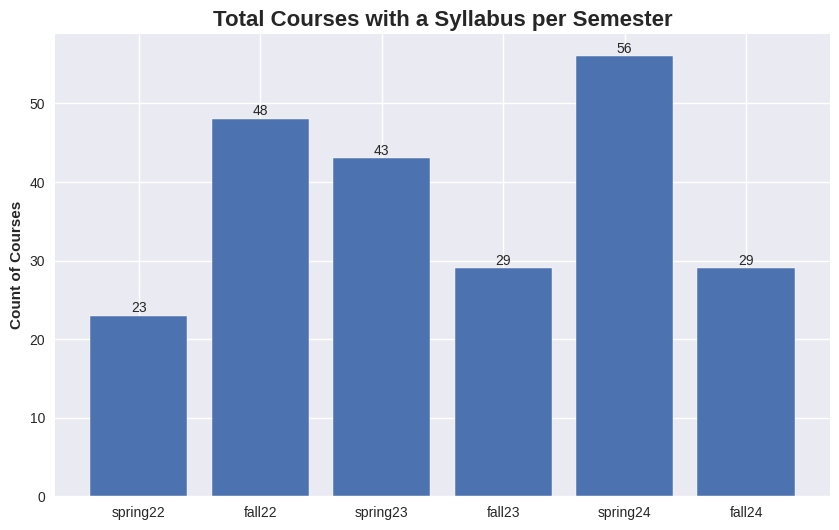

In [ ]:
semester_counts = final_table[all_sems[::-1]].sum(axis=0)

plt.figure(figsize=(10, 6))
plt.bar(semester_counts.index, semester_counts.values)
plt.xlabel("")
plt.ylabel("Count of Courses").set_fontweight('bold')
plt.title("Total Courses with a Syllabus per Semester", fontdict={"weight":"bold","size":16})

# add data labels on top of each bar
for i, value in enumerate(semester_counts):
    plt.text(i, value + 0.1, f"{value}", ha='center', va='bottom')
plt.show()

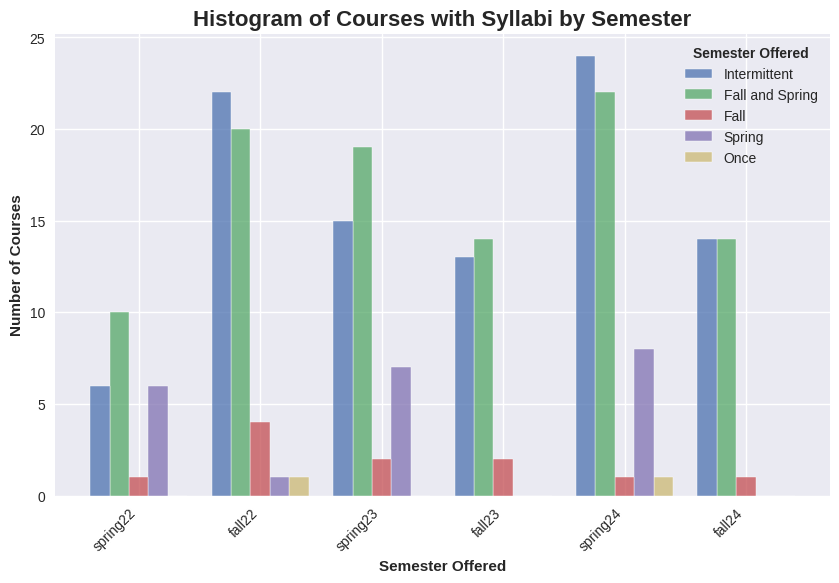

In [ ]:
# prompt: using seaborn, generate a histogram of courses that submitted a syllabus over the semesters in final_table, grouped by "SemesterOffered"

# Melt the DataFrame to long format
melted_data = pd.melt(final_table, id_vars=['CourseID', 'SemesterOffered'], value_vars=all_sems[::-1], var_name='Semester', value_name='HasSyllabus')

# Filter for courses with a syllabus (HasSyllabus == 1)
melted_data = melted_data[melted_data['HasSyllabus'] == 1]

semester_offered_order = ['Intermittent', 'Fall and Spring', 'Fall', 'Spring','Once']

# Create the histogram
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=melted_data, x='Semester', hue="SemesterOffered", multiple="dodge", shrink=0.8, legend=True, hue_order=semester_offered_order)
plt.title("Histogram of Courses with Syllabi by Semester", fontdict={"weight":"bold","size":16})
plt.xlabel("Semester Offered").set_fontweight('bold')
plt.ylabel("Number of Courses").set_fontweight('bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# # Customizing the legend
legend = ax.get_legend()
legend.set_title("Semester Offered")
plt.setp(legend.get_title(), weight='bold') # Set the title font weight to bold

plt.show()


In [ ]:
# getting year_mapping - can comment out below
# # Desired order of semester offered groups - correcting num sem
# desired_order = ['Intermittent', 'Fall and Spring', 'Fall', 'Spring']
# correct_year = [2,6,3,3]

# # Create a dictionary to map SemesterOffered to correct_year
# year_mapping = dict(zip(desired_order, correct_year))

# Calculate the number of courses that re-submitted their syllabus over the years
resubmitted_courses = final_table[final_table['NumSem'] > 1]
corrected_resubmitted_courses = final_table[final_table['Consistency'] > (1 / final_table['SemesterOffered'].map(year_mapping))*100]

# Calculate the number of re-submitted courses
num_resubmitted = len(resubmitted_courses)

print(f"Total courses that re-submitted their syllabus: {num_resubmitted}, {(num_resubmitted/len(final_table))*100:.02f}%")

# Group by "Semester Offered" and count the number of re-submitted courses
resubmitted_by_semester = resubmitted_courses.groupby("SemesterOffered")["CourseID"].count()
corrected_resubmitted_by_semester = corrected_resubmitted_courses.groupby("SemesterOffered")["CourseID"].count()

# concatinate two version
resubmits_table = pd.concat([resubmitted_by_semester, corrected_resubmitted_by_semester], axis=1)
resubmits_table.columns = ['Total Counts', 'Corrected Counts']

# same code as above, uncomment if needed
#semester_offered_order = ['Intermittent', 'Fall and Spring', 'Fall', 'Spring','Once']

# Reorder the DataFrame based on the desired order
resubmits_table = resubmits_table.reindex(semester_offered_order)

# make the table pretty
resubmits_table = resubmits_table.dropna()
resubmits_table = resubmits_table.astype(int)

# resubmitted_by_semester
print("\nNumber of re-submitted courses by semester offered:")
display(resubmits_table)

Total courses that re-submitted their syllabus: 65, 72.22%

Number of re-submitted courses by semester offered:


,Total Counts,Corrected Counts
SemesterOffered,,
Intermittent,31,31
Fall and Spring,22,22
Fall,4,4
Spring,8,8


## Syllabi Text Analysis

In [ ]:
## function to lemmatize
nlp = spacy.load("en_core_web_sm")

# lemmatizing text
def lemmatize(text):

    # Process the text with spaCy
    doc = nlp(text.lower())

    # Extract lemmatized tokens
    lemmatized_text = " ".join([token.lemma_ for token in doc])

    return lemmatized_text

In [ ]:
# read and lemmatize all texts in syllabi collection - takes a bit for 2 mins for 80 pdfs
collection = {}

for course in tqdm(syllabus_link):
    reader = PdfReader(syllabus_link[course])
    text=''
    for page in reader.pages:
        text += page.extract_text() + "\n"
    pair = syllabus_link[course].split('/')[-1].split('-')
    pair[1] = pair[1].replace('.pdf', '')
    collection[tuple(pair)] = lemmatize(text)

100%|██████████| 90/90 [03:10<00:00,  2.11s/it]


In [ ]:
save(collection, 'collection')

In [ ]:
collection = load('collection')

In [ ]:
# Get a list of all keys in the collection dictionary
keys = list(collection.keys())

# Generate a random index within the range of keys
random_index = random.randint(0, len(keys) - 1)

# Get the random key using the random index
random_key = keys[random_index]

# Now you can use random_key to access values in the collection dictionary
print(f"Random Course: {random_key}")
print(f"First 300 Words in for Random Course:\n {collection[random_key][:300]}")

Random Course: ('70436', 'Applied Projects for Business and Economics')
First 300 Words in for Random Course:
 70436 apply project for business and economic 
 spring 2024 
 instructor : vaibhav keshav time : w 5 pm – 6 pm 
 email : vkamble@andrew.cmu.edu place : tep 5239 
 course page : 
 1 . https://canvas.cmu.edu/courses/40185/announcement 
 course description : 
 apply project for business and economic be


In [ ]:
# filter syllabi for keywords
assessments = {'exam', 'project', 'case', 'simulation', 'paper', 'report', 'client', 'presentation'}
experientialLearning = {'experiential learning', 'reflection', 'apply'}

assessmentCounter, experientialCounter = Counter(), Counter()
assessment_Dict, experientialDict = {assessment:[] for assessment in assessments}, {experience:[] for experience in experientialLearning}

for course in collection:
    for assessment in assessments:
        if assessment in collection[course]:
            assessmentCounter[assessment] += 1
            assessment_Dict[assessment].append(course)

    for experience in experientialLearning:
        if experience in collection[course]:
            experientialCounter[experience] += 1
            experientialDict[experience].append(course)

# test one of the counters
assessmentCounter.most_common(2)

[('exam', 80), ('case', 80)]

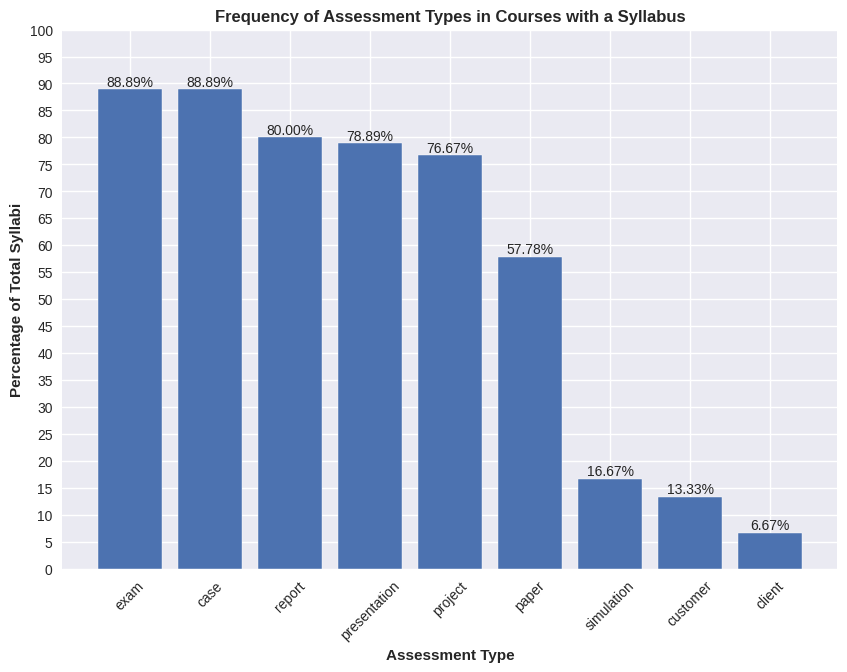

In [ ]:
## visualize frequency by assessment types

# get assessment names and total count
assessment,count = zip(*assessmentCounter.most_common())

count = list(count)

# get frequency
for num in count:
  count[count.index(num)] = round(num/len(syllabus_link)*100, 2)

# plot a bar chart
plt.figure(figsize=(10, 7))
plt.bar(assessment, count)
plt.xticks(rotation = 45)
plt.yticks(range(0, 105, 5))
plt.title("Frequency of Assessment Types in Courses with a Syllabus").set_fontweight('bold')
plt.xlabel("Assessment Type").set_fontweight('bold')
plt.ylabel("Percentage of Total Syllabi").set_fontweight('bold')

# add data labels on top of each bar
for i, value in enumerate(count):
    plt.text(i, value + 0.1, f'{value:.02f}%', ha='center', va='bottom')

plt.show()

In [ ]:
# prints courses that mention a client
client_courses = assessment_Dict['client']

for i, course in enumerate(client_courses):
    print(f"{i+1}. {course[0]} - {course[1]}")

1. 70340 - Business Communication
2. 70354 - Communication Social Media in Action
3. 70440 - Corporate Strategy
4. 70447 - Client Consulting Project, Strategic Management of the Enterprise
5. 70497 - Derivatives Securities
6. 73497 - Economics Senior Project


In [ ]:
# prints courses that mention a project
project_courses = assessment_Dict['project']

for i, course in enumerate(project_courses):
    print(f"{i+1}. {course[0]} - {course[1]}")

1. 70100 - Global Business
2. 70207 - Probability and Statistics for Business Applications
3. 70208 - Regression Analysis
4. 70311 - Organization Beahvior
5. 70340 - Business Communication
6. 70342 - Managing Across Cultures
7. 70373 - Sustainable Operations
8. 70374 - Data Mining & Business Analytics
9. 70416 - New Venture Creation
10. 70417 - Topics in Entrepreneurship
11. 73065 - Nudging Behavior in Business and Public Policy
12. 73230 - Intermediate Microeconomics
13. 73265 - Economics and Data Science
14. 73270 - Professional Communication for Economists
15. 73274 - Econometrics I
16. 73341 - Managing through Incentives
17. 73348 - Behavioral Economics
18. 73423 - Forcasting for Economics and Business
19. 70104 - Business Leadership Endeavor I
20. 70110 - Business Computing
21. 70204 - Business Leadership Endeavor II
22. 70246 - Innovation & The Entrepreneurial Mindset
23. 70304 - Business Leadership Endeavor III
24. 70318 - Managing Effective Work Teams
25. 70332 - Business, Soci

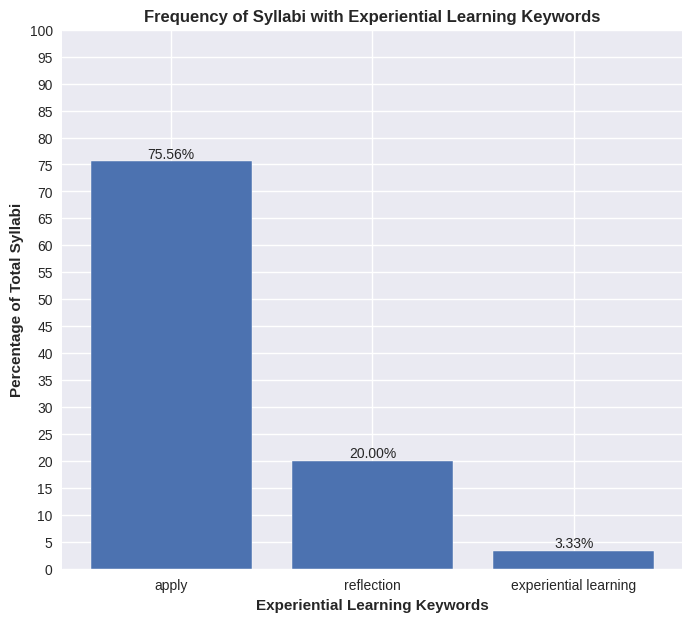

In [ ]:
## visualize frequency by experiential experiences
experience,count = zip(*experientialCounter.most_common())

count = list(count)

# get frequency
for num in count:
  count[count.index(num)] = round(num/len(syllabus_link)*100, 2)

# plot the bar chart
plt.figure(figsize=(8, 7))
plt.bar(experience, count)
plt.yticks(range(0, 105, 5))
plt.title("Frequency of Syllabi with Experiential Learning Keywords").set_fontweight('bold')
plt.xlabel("Experiential Learning Keywords").set_fontweight('bold')
plt.ylabel("Percentage of Total Syllabi").set_fontweight('bold')

# add data labels on top of each bar
for i, value in enumerate(count):
    plt.text(i, value + 0.1, f"{value:.02f}%", ha='center', va='bottom')

plt.show()

In [ ]:
# prints courses that mention reflection
reflection_courses = experientialDict['reflection']

for i, course in enumerate(reflection_courses):
    print(f"{i+1}. {course[0]} - {course[1]}")

1. 70100 - Global Business
2. 70340 - Business Communication
3. 70416 - New Venture Creation
4. 73102 - Principles of Microeconomics
5. 70104 - Business Leadership Endeavor I
6. 70204 - Business Leadership Endeavor II
7. 70246 - Innovation & The Entrepreneurial Mindset
8. 70304 - Business Leadership Endeavor III
9. 70318 - Managing Effective Work Teams
10. 70341 - Team Dynamics and Leadership
11. 70381 - Marketing I
12. 70415 - Introduction to Entrepreneurship
13. 70483 - Advising and Marketing Communication
14. 73210 - Economics Colloquium I
15. 70321 - Negotiation and Conflict Resolution
16. 70452 - Introduction to Product Management
17. 70485 - Product & Brand Management
18. 70499 - Internship


In [ ]:
# prints courses that mention experiential learning
experiential_courses = experientialDict['experiential learning']

for i, course in enumerate(experiential_courses):
    print(f"{i+1}. {course[0]} - {course[1]}")

1. 70318 - Managing Effective Work Teams
2. 70447 - Client Consulting Project, Strategic Management of the Enterprise
3. 73497 - Economics Senior Project


In [ ]:
# creates folder to store results
os.makedirs('./project', exist_ok=True)
os.makedirs('./reflection', exist_ok=True)
os.makedirs('./client_experiential', exist_ok=True)
os.makedirs('./project_reflection', exist_ok=True)

In [ ]:
# copy all syllabi that mentions experiential learning to client_experiential folder
for course in experiential_courses:
  source = syllabus_link[course[0]]
  destination = f"./client_experiential/{course[0]}-{course[1]}.pdf"
  shutil.copy(source, destination)

In [ ]:
# copy all syllabi that mentions a client to client_experiential folder
for course in client_courses:
  source = syllabus_link[course[0]]
  destination = f"./client_experiential/{course[0]}-{course[1]}.pdf"
  shutil.copy(source, destination)

In [ ]:
# remove courses from client_courses and experiential_courses from project_courses and reflection_courses:
filtered_project = set(project_courses) - set(client_courses) - set(experiential_courses)
filtered_reflection = set(reflection_courses) - set(client_courses) - set(experiential_courses)

In [ ]:
# copy all syllabi that mention a project and reflection from the filtered sets to project_reflection
project_reflection = filtered_project & filtered_reflection

for course in project_reflection:
  source = syllabus_link[course[0]]
  destination = f"./project_reflection/{course[0]}-{course[1]}.pdf"
  shutil.copy(source, destination)

In [ ]:
# remove project_reflection from the filtered project and filtered reflection sets then move to their folders accordingly
filtered_project = set(filtered_project) - set(project_reflection)
filtered_reflection = set(filtered_reflection) - set(project_reflection)

for course in filtered_project:
  source = syllabus_link[course[0]]
  destination = f"./project/{course[0]}-{course[1]}.pdf"
  shutil.copy(source, destination)

for course in filtered_reflection:
  source = syllabus_link[course[0]]
  destination = f"./reflection/{course[0]}-{course[1]}.pdf"
  shutil.copy(source, destination)

In [ ]:
# flush out all folders
shutil.rmtree('./project')
shutil.rmtree('./reflection')
shutil.rmtree('./client_experiential')
shutil.rmtree('./project_reflection')

## Additional Analyses

This section includes additional analytics that did not make it to the report. It could be that information was not helpful or interesting enough.

In [ ]:
# functions
num_top_words = 20

# printing the top words within chosen topics
def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

# calculating log prob of word1 given word2
def log_prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (syllabus_vectors[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (syllabus_vectors[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

# topic coherent metric
def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    average_coherence = 0
    for topic_idx in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx, ']', sep='')

        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        coherence = 0.
        for top_word_idx1 in sort_indices[:num_top_words]:
            word1 = vocab[top_word_idx1]
            for top_word_idx2 in sort_indices[:num_top_words]:
                word2 = vocab[top_word_idx2]
                if top_word_idx1 != top_word_idx2:
                    coherence += log_prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)

        if verbose:
            print('Coherence:', coherence)
            print()
        average_coherence += coherence
    average_coherence /= num_topics
    if verbose:
        print('Average coherence:', average_coherence)
    return average_coherence

# calculating num of unique words
def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    average_number_of_unique_top_words = 0
    for topic_idx1 in range(num_topics):
        if verbose:
            print('[Topic ', topic_idx1, ']', sep='')

        sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
        num_unique_top_words = 0
        for top_word_idx1 in sort_indices1[:num_top_words]:
            word1 = vocab[top_word_idx1]
            break_ = False
            for topic_idx2 in range(num_topics):
                if topic_idx1 != topic_idx2:
                    sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
                    for top_word_idx2 in sort_indices2[:num_top_words]:
                        word2 = vocab[top_word_idx2]
                        if word1 == word2:
                            break_ = True
                            break
                    if break_:
                        break
            else:
                num_unique_top_words += 1
        if verbose:
            print('Number of unique top words:', num_unique_top_words)
            print()

        average_number_of_unique_top_words += num_unique_top_words
    average_number_of_unique_top_words /= num_topics

    if verbose:
        print('Average number of unique top words:', average_number_of_unique_top_words)

    return average_number_of_unique_top_words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD

In [ ]:
k_values = range(2, 11)
avg_coherences = []
avg_num_unique_words = []

vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1, max_features = 1000)
syllabus_vectors = vectorizer.fit_transform([course[1] for course in collection])

for k in k_values:
    svd_candidate = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=0)
    svd_candidate.fit(syllabus_vectors)
    topic_word_distributions = np.array([row / row.sum() for row in svd_candidate.components_])
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, False))

In [ ]:
k_values = range(2, 11)
avg_coherences = []
avg_num_unique_words = []

vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1, max_features = 1000)
syllabus_vectors = vectorizer.fit_transform([course[1] for course in collection])

for k in k_values:
    lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
    lda_candidate.fit(syllabus_vectors)
    topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
    avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, False))
    avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, False))

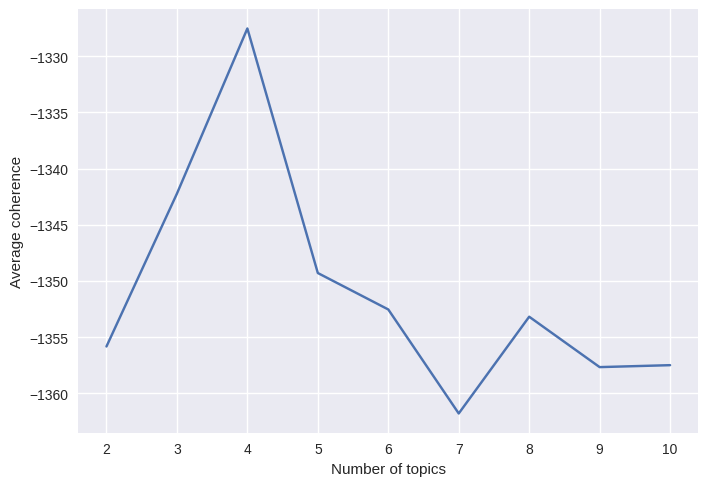

In [ ]:
# ploting coherence
plt.Figure(figsize=(8, 6))
plt.plot(k_values, avg_coherences)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

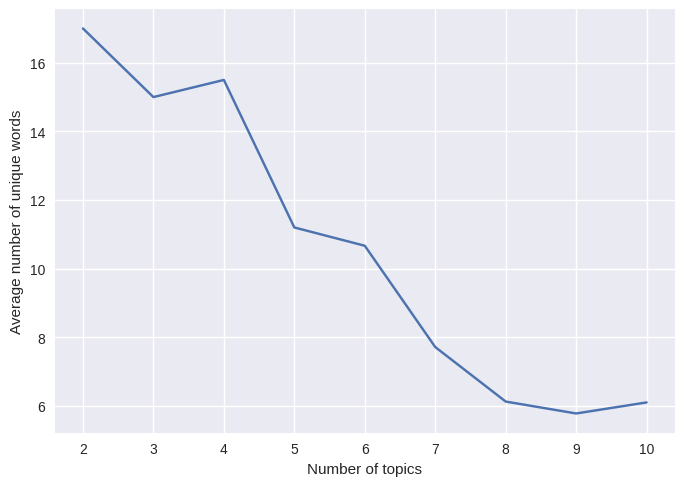

In [ ]:
# plting av. number of unique words
plt.Figure(figsize=(8, 6))
plt.plot(k_values, avg_num_unique_words)
plt.xlabel('Number of topics')
plt.ylabel('Average number of unique words')
plt.show()

In [ ]:
# 7 top words
lda_candidate = LatentDirichletAllocation(n_components=5, random_state=0)
lda_candidate.fit(syllabus_vectors)
topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])

print('-' * 80)
print('Number of topics:', k)
print()
print_top_words(topic_word_distributions, num_top_words, vectorizer)
print()
print()

--------------------------------------------------------------------------------
Number of topics: 10

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
business : 0.2615931672346375
analytics : 0.05862078399386158
economics : 0.0551277214627541
leadership : 0.043111521327938995
endeavor : 0.041301810688852324
mining : 0.030505343035240967
end : 0.029347367883295655
applications : 0.02653490304033831
communication : 0.026091480385900163
data : 0.0191787030706518
financial : 0.018559871254414145
texts : 0.016180608633984853
language : 0.016180608633984853
graphs : 0.016180608633984853
game : 0.015179343511250673
ii : 0.014550100551766351
thery : 0.014440028674162384
iii : 0.013939324801868424
machine : 0.013441757016972783
learning : 0.013441757016972783

[Topic 1]
management : 0.28440117642713647
data : 0.07263387155645153
strategic : 0.07089644627467276
product : 0.0571606480323186
project : 0.04712839453366668
consulting : 0.0445209787460037

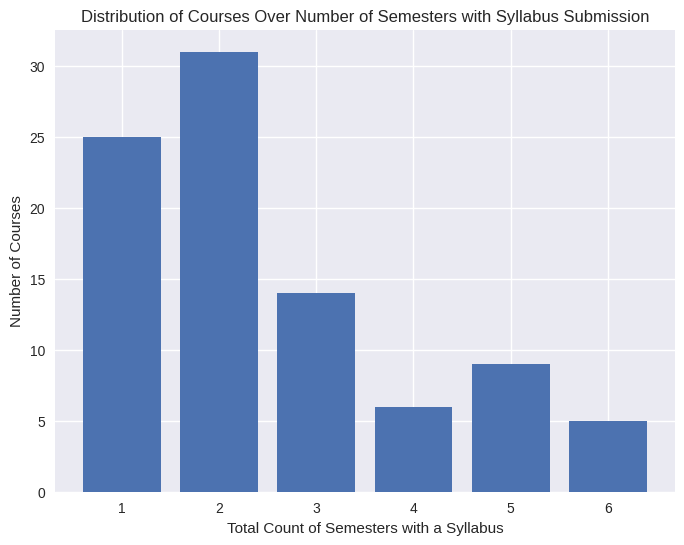

In [ ]:
# prompt: Using dataframe has_syllabus: Make a pyplot count- bar graph where the x axis is the number of semesters a course submitted a syllabus (nunsem)

# Calculate the counts for each number of semesters
semester_counts = final_table['NumSem'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(semester_counts.index, semester_counts.values)
plt.xlabel('Total Count of Semesters with a Syllabus')
plt.ylabel('Number of Courses')
plt.title('Distribution of Courses Over Number of Semesters with Syllabus Submission')
plt.xticks(semester_counts.index)  # Ensure all semester values are shown on the x-axis
plt.show()

In [ ]:
# lemmatize course names for all courses that have syllabus
topics = Counter()

for course in all_courses[all_courses['HasSyllabus']==1]['CourseName']:
    topic = lemmatize(course).split()
    for word in topic:
        if word.isalpha() and not (nlp.vocab[word].is_stop):
            topics[word] += 1

# check the top words
topics.most_common(2)

[('business', 10), ('marketing', 4)]

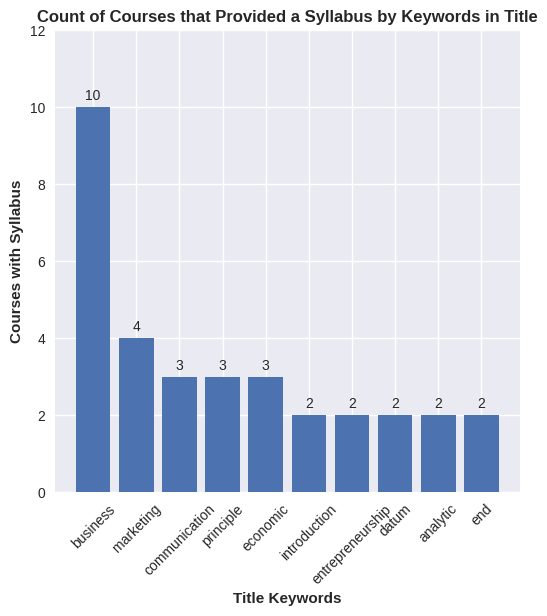

In [ ]:
# visualize top courses that provided a syllabus

topic,count = zip(*topics.most_common(10))

plt.figure(figsize=(6, 6))
plt.bar(topic, count)
plt.xticks(rotation = 45)
plt.yticks(range(0, 14, 2))
plt.title("Count of Courses that Provided a Syllabus by Keywords in Title").set_fontweight('bold')
plt.xlabel("Title Keywords").set_fontweight('bold')
plt.ylabel("Courses with Syllabus").set_fontweight('bold')

# adds data labels on top of each bar
for i, value in enumerate(count):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()